In [1]:
import numpy as np

In [2]:
from tqdm import tqdm

In [3]:
def relu(x):
    return np.where(x >= 0, 
                        x, 
                        0)

In [4]:
def get_activation(activation):#maybe getderivatives here iteself ?
    def sigmoid(x):
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    def softmax(x):
        z=x-np.max(x,axis=0)
        return np.exp(z)/np.sum(np.exp(z),axis=0)
    def relu(x):
        rel=np.where(x >= 0, 
                            x, 
                            0)
        return rel
    if activation=='sigmoid':
        return sigmoid
    elif activation=='softmax':
        return softmax
    elif activation== 'tanh':
        return np.tanh
    elif activation== 'relu':
        return relu

In [5]:
def get_activation_derivative(activation):#maybe getderivatives here iteself ?
    def sigmoid_d(x):
        sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        return sig*(1-sig)
    def softmax_d(x):
        z=x-np.max(x,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)
    def tanh_d(x):
        return 1-np.tanh(x)**2
    def relu_d(x):
        return np.where(x >= 0, 
                            1, 
                            0)
    
    if activation=='sigmoid':
        return sigmoid_d
    elif activation=='softmax':
        '''
        need to think more, not required for backprop as we look directly at dL/da_l
        But still, for the sake of completeness, and if user wants softmax in the middle?
        d S(x_i) /d x_j= S(x_i)*(kronecker delta_i,j -S(x_j))
        But we care about only dh_k,j/da_k,j So no need to implement d S(x_i) /d x_j
        d S(x_i) /d x_i should suffice
        so we get array of [ d S(x_1) /d x_1, d S(x_2) /d x_2, ....]
        
        For MSE loss after softmax, we need cross terms...
        '''
        
        return softmax_d
    elif activation=='tanh':
        return tanh_d
    elif activation=='relu':
        return relu_d
    assert(activation=='relu'or activation=='tanh'or activation=='sigmoid' or activation=='softmax'), 'Must be \'relu\'or \'tanh\' or \'sigmoid\' or \'softmax\' '


In [6]:
def get_loss(loss='cross-entropy'):
    
   
    
    safety=1e-30    
    def crossentropy(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum([-np.dot(P[:,i],np.log2(Q[:,i]+safety)) for i in range(P.shape[1])])
    def SE(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum(np.square(P-Q))
    
    if loss=="SE":
        return SE
    return crossentropy
    
    
      
    
    
    
    

In [7]:
def get_loss_derivative(loss):
    def SE_d(y_in,y_pred_in):
        '''
        derivative of MSE after softmax is used to get probabs from a_L:
        We need indicator because the all terms of y_true are required unlike cross-entropy where only y_pred[l] is required
        Thus transforming the stacked indicator to y_true, not here...
        
        '''

        def indicator(i,j):
                if i==j:
                    return 1
                return 0


        assert(y_in.shape[0]==y_pred_in.shape[0]),"Inputs must contain same number of examples"

        y=y_in.ravel()
        y_pred=y_pred_in.ravel()


        return np.array([
            [2*np.sum([(y_pred[i]-y[i])*y[i]*(indicator(i,j) - y_pred[j]) for i in range(y.shape[0])])]
            for j in range(len(y))
        ])    
   
    
        
    def crossentropy_d(y,y_pred):
        

        return -(y-y_pred)
    
    
    if loss=="cross-entropy":
        return crossentropy_d
    return SE_d
    

In [8]:
class layer:
    def __init__(self,input_size,output_size,activation='sigmoid',batch_size=2,type_='random'):
            
        ''' 
        output size number of neurons i
        input size j
        
        '''
        assert(type_=='random'or type_=='xavier'or type_=='glorot' or type_=='He' ), 'Must be \'random\'or \'xavier\' or \'glorot\' or \'He\' '
        
        if type_=='random':
            scale=0.01
            self.W=np.random.randn(output_size,input_size)*scale #size ixj
            self.b=np.zeros((output_size,1))         #size i
            
        elif type_=='xavier' or type_=='glorot':
            # Xavier Uniform
            r=np.sqrt(6/(input_size+output_size))
            self.W=np.random.uniform(-r,r,(output_size,input_size))
            self.b=np.zeros((output_size,1))
            
        else:#He
            self.W= np.random.randn(output_size,input_size)*np.sqrt(2/input_size)
            self.b=np.zeros((output_size,1))
            
                
            
            
            
        self.a=np.zeros((output_size,batch_size))          #size i
        self.h=np.zeros((output_size,batch_size))         #size i
        self.g=get_activation(activation)
        
        self.d_a=np.zeros((output_size,batch_size))
        self.d_h=np.zeros((output_size,batch_size))
        self.d_W=np.zeros((output_size,input_size))
        self.d_b=np.zeros((output_size,1))
        self.d_g=get_activation_derivative(activation)
        
        
        
    def forward(self, inputs):
        self.a=self.b+np.matmul(self.W,inputs)
        self.h=self.g(self.a)
        return self.h
    def reset(self):
        self.d_a=np.zeros(np.shape(self.d_a))
        self.d_h=np.zeros(np.shape(self.d_h))
        self.d_W=np.zeros(np.shape(self.d_W))
        self.d_b=np.zeros(np.shape(self.d_b))
        
    def hard_set(self,W,b):#hardsets the weight. useful for debugging
        self.W=W
        self.b=b
        


In [9]:
class Model:
    def __init__(self,X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m,batch_size):
        '''
        '''   
        
        self.input_size=X_size
        self.output_size=Y_size
        self.hidden_layer_sizes=hidden_layer_sizes
        self.layers=[]
        self.batch_size=batch_size
        
        prev_size=self.input_size

        assert(len(hidden_layer_sizes)==len(hidden_layer_activations)==len(hidden_layer_initializations)), 'lengths of layer sizes, activations and initializations don\'t match'
        for size,activation,inits in zip(hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations):

            self.layers.append(layer(prev_size,size,activation,batch_size,inits))
            prev_size=size
        self.layers.append(layer(size,self.output_size,'softmax',batch_size,'xavier'))
        
        self.loss=get_loss(loss)#without regularization term
        self.loss_d=get_loss_derivative(loss)
        self.lamdba_m=lamdba_m #we shall pass lambda/m to this, where m is patch size
        
    def forward(self,x):
        output=x
        
        for layer in  self.layers:
            output=layer.forward(output)  
        return output
    
    def backward(self,x,y,y_pred):
        # self.layers[-1].d_h is not needed as d_h is used to calculate d_a and self.layers[-1].h is softmax
        self.layers[-1].d_a=self.loss_d(y,y_pred)
            
        
        
        for idx in range(len(self.layers)-1,0,-1): #goes from L->2, for l=1 we do outside
            
            
            #compute gradient wrt parameters
            self.layers[idx].d_W=np.dot(self.layers[idx].d_a,np.transpose(self.layers[idx-1].h))+self.lamdba_m*self.layers[idx].W
            self.layers[idx].d_b=np.sum(self.layers[idx].d_a,axis=1,keepdims=True)
            
            #compute gradient wrt layer below -- will help in next layer iter
            self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)
            
            #compute gradient -- element wise multiplivation, derivative of the activation function of layer idx-1
            self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)
        assert(idx-1==0)
                        
        self.layers[0].d_W=np.dot(self.layers[0].d_a,np.transpose(x))+self.lamdba_m*self.layers[0].W
        self.layers[0].d_b=np.sum(self.layers[0].d_a,axis=1,keepdims=True)
        
        
        
    def predict(self,Xtest):
        
        return self.forward(Xtest)
    
    
        
        
                    
                
                
            
            
            
        
    
            
            
        
            
            

In [32]:
class optimizers:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['relu'],hidden_layer_initializations=['He'],
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=1,epochs=10,eta=1e-3,ES=False):

        self.batch_size=batch_size
        self.epochs=epochs
        self.train_loss=[]
        self.val_loss=[]
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m=lamdba/self.batch_size,batch_size=self.batch_size)
        self.learning_rate=eta
        self.optimizer=optimizer
        self.ES=ES
        if self.ES:
            self.ES_best_val_loss=1e30
            self.ES_paitence=3
            self.ES_model=None
            self.ES_epoch=-1
        

        
        
    def iterate(self,updator,X,Y,Xval,Yval):
        reminder=X.shape[1]%self.batch_size #uneven batch size
        
        for t in tqdm(range(self.epochs)):
            for i in range(0,np.shape(X)[1]-self.batch_size,self.batch_size):
                x=X[:,i:i+self.batch_size]
                y=Y[:,i:i+self.batch_size]
                y_pred=self.model.forward(x)
    
    
                self.model.backward(x,y,y_pred)
                updator(t)

            if reminder:

                x=np.hstack((X[:,i+self.batch_size:],X[:,:reminder]))
                y=np.hstack((Y[:,i+self.batch_size:],Y[:,:reminder]))
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                updator(t)
            self.loss_calc(X,Y,Xval,Yval)
            if self.ES:
                if self.ES_best_val_loss>self.val_loss[-1]:
                    self.ES_best_val_loss=self.val_loss[-1]
                    self.ES_model=copy.deepcopy(self.model)
                    self.patience=3
                    self.ES_epoch=t
                else:
                    self.patience-=1
                    if not self.patience:
                        print('Early stopping at epoch: ',t, "reverting to epoch ", self.ES_epoch)
                        self.loss_calc_ES(X,Y,Xval,Yval)
                        return self.ES_model
                
            
            
            
    def loss_calc(self,X,Y,Xval,Yval):
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    def loss_calc_ES(self,X,Y,Xval,Yval):
            regularization=1/2*self.ES_model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.ES_model.layers])
            self.train_loss.append((self.ES_model.loss(Y,self.ES_model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.ES_model.loss(Yval,self.ES_model.predict(Xval))/Xval.shape[1])            


        
        

    def batch_gradient_descent(self,traindat,testdat):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X)[1], behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        def update_batch(_):
            for layer in self.model.layers:
                layer.W=layer.W-self.learning_rate*layer.d_W
                layer.b=layer.b-self.learning_rate*layer.d_b
 
        

        updator=update_batch
        self.iterate(updator,X,Y,Xval,Yval)

            
    def momentum(self,traindat,testdat,beta=0.9):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_mom(_):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                u_W[i]=beta*u_W[i]+layer.d_W
                u_b[i]=beta*u_b[i]+layer.d_b
                layer.W=layer.W-self.learning_rate*u_W[i]
                layer.b=layer.b-self.learning_rate*u_b[i]
        
        updator=update_mom
        self.iterate(updator,X,Y,Xval,Yval)
            

    def rmsprop(self,traindat,testdat,beta=0.9,epsilon=1e-10):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_rms(_):
                for i in range(len(self.model.layers)):                 
                    layer=self.model.layers[i]
                    v_W[i]=beta*v_W[i]+(1-beta)*layer.d_W**2
                    v_b[i]=beta*v_b[i]+(1-beta)*layer.d_b**2
                    layer.W=layer.W-(self.learning_rate/np.sqrt(v_W[i]+epsilon))*layer.d_W
                    layer.b=layer.b-(self.learning_rate/np.sqrt(v_b[i]+epsilon))*layer.d_b



        updator=update_rms
        self.iterate(updator,X,Y,Xval,Yval)
            
    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_adam(t):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                #updating momentum, velocity
                m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b

                v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2

                m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                v_b_hat=v_b[i]/(1-np.power(beta2,t+1))



                layer.W=layer.W-(self.learning_rate*m_W_hat)/(np.sqrt(v_W_hat)+epsilon)
                layer.b=layer.b-(self.learning_rate*m_b_hat)/(np.sqrt(v_b_hat)+epsilon)

            
        
        
        
        



        updator=update_adam
        self.iterate(updator,X,Y,Xval,Yval)
    
    def NAG(self,traindat,testdat,beta=0.9):
        
        ''''''
        
        X,Y=traindat
        
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        def update_nag(_):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                m_W[i]=beta*m_W[i]+self.learning_rate*layer.d_W
                m_b[i]=beta*m_b[i]+self.learning_rate*layer.d_b


                layer.W=layer.W-(beta*m_W[i]+self.learning_rate*layer.d_W[i])
                layer.b=layer.b-(beta*m_b[i]+self.learning_rate*layer.d_b[i])
            
        updator=update_nag
        self.iterate(updator,X,Y,Xval,Yval)
    
    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        def update_nadam(t):
            for i in range(len(self.model.layers)):
                layer=self.model.layers[i]
                #updating momentum, velocity
                m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b

                v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2

                m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                v_b_hat=v_b[i]/(1-np.power(beta2,t+1))



                layer.W=layer.W-(self.learning_rate/(np.sqrt(v_W_hat)+epsilon))*\
                (beta1*m_W_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_W)
                layer.b=layer.b-(self.learning_rate/(np.sqrt(v_b_hat)+epsilon))*\
                (beta1*m_b_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_b)            
        
        


        updator=update_nadam
        self.iterate(updator,X,Y,Xval,Yval)

    def run(self,traindat,testdat,beta=0.9,beta1=0.9, beta2=0.999,epsilon=1e-10):
        "sgd", "batch", "momentum", "nag", "rmsprop", "adam", "nadam"
        
        if self.optimizer=="batch":
            self.batch_gradient_descent(self,traindat,testdat)
            
        elif self.optimizer=="sgd":
            assert(self.batch_size==1), "Batch size should be 1 for stochastic gradient descent"
            self.batch_gradient_descent(self,traindat,testdat)
            
        elif self.optimizer=="momentum":
            self.momentum(traindat,testdat,beta)
            
            
        elif self.optimizer=="nag":
            self.NAG(traindat,testdat,beta)
            
            
        elif self.optimizer=="rmsprop":
            self.rmsprop(traindat,testdat,beta=0.9,epsilon=1e-10)
            
        elif self.optimizer=="adam":
            self.Adam(traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10)

            
            
        elif self.optimizer=="nadam":
            self.NAdam(traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10)

            
            
        else:
            print("Invalid optimizer name "+ self.optimizer)
            return(0)
            



# Import Dataset

In [11]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

def one_hot(inarray): #converts to one hot encoding
    outarray = np.zeros((inarray.size, inarray.max() + 1))
    outarray[np.arange(inarray.size), inarray] = 1
    return outarray

def Preprocess(X,y):
      
    '''Unrolls X,y, rehsapes into column vectors, one hots y'''
    assert(X.shape[0]==y.shape[0]),"Inputs must contain same number of examples, stored in rows" #checks if same dim
    
    X_processed=np.reshape(X,(X.shape[0],784))/255
    X_processed=X_processed.T
    y_processed=one_hot(y).T
    return np.array(X_processed),y_processed
        
    



Xtest,ytest=Preprocess(X_test,y_test)

from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,test_size=0.1)
Xtrain,ytrain=Preprocess(Xtrain,ytrain)
Xval,yval=Preprocess(Xval,yval)

2023-03-17 00:38:48.017423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 00:38:48.091779: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 00:38:48.108683: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-17 00:38:48.360990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [33]:
def accuracy_check(Y,Ypred):
    return np.sum(np.argmax(Ypred,axis=0)==np.argmax(Y,axis=0))/Y.shape[1]
    
    
    

In [34]:
import matplotlib.pyplot as plt
import copy

In [36]:
np.random.seed(0)
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['relu','relu','relu'],['He','He','He'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=40,eta=1e-3)


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:40<00:00,  1.01s/it]

0.3680505842767108 0.5121885874999511
Accuracy train 0.9068888888888889
Accuracy val 0.8745


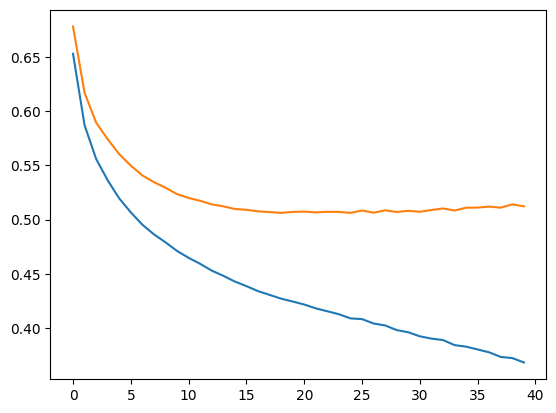

In [37]:
opt.run((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [38]:
np.random.seed(0)
optES=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['relu','relu','relu'],['He','He','He'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=40,eta=1e-3,ES=True)


 52%|███████████████████████████████████████████▌                                       | 21/40 [00:21<00:19,  1.03s/it]

Early stopping at epoch:  21 reverting to epoch  18
0.4269515193862658 0.5061381947207892
Accuracy train 0.8956111111111111
Accuracy val 0.8735


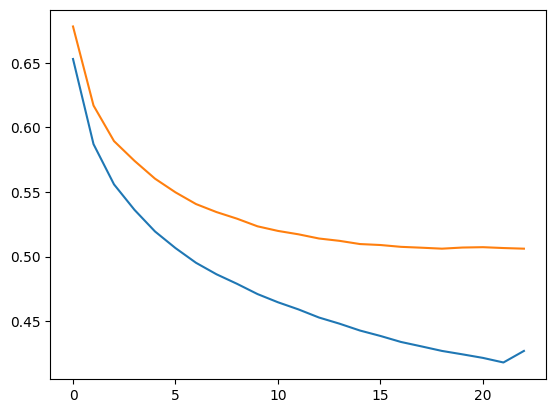

In [39]:

optES.run((Xtrain,ytrain),(Xval,yval))
plt.plot(optES.train_loss)
plt.plot(optES.val_loss)




print(optES.train_loss[-1],optES.val_loss[-1])

print('Accuracy train',accuracy_check(optES.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(optES.model.predict(Xval),yval))